### Comparing t-SNE and VAE Embeddings on MNIST
In this experiment, we compare two techniques for generating 2D embeddings of the MNIST dataset: t-SNE, a popular non-linear dimensionality reduction method, and Variational Autoencoders (VAEs), a type of generative deep learning model. Our goal is to visualize how these methods organise the MNIST data in a latent space.

### The Models
#### Model #1: Conventional VAE
We construct a standard VAE that serves as our baseline for comparison.

#### Model #2: t-SNE Embedded VAE
This slightly unorthodox approach first applies t-SNE for dimensionality reduction on the MNIST dataset, creating a structured latent space. We then train a VAE's encoder to learn to produce this structure in a supervised manner, followed by training the decoder with the encoder's weights frozen.

### Evaluation Criteria
- **Latent Space Quality**: We assess the quality of each model's latent space. A well-structured latent space should show continuity without overly uniform or densely packed areas.

- **Encoder Performance**: We use the encoders' outputs to train support vector machine (SVM), random forest (RF), and K-nearest neighbours (KNN) classifiers. Their performance on MNIST validation data will help evaluate the latent space structure's quality.

- **Full Model Performance**: By comparing the original images with those generated by passing validation images through the full VAE (encoder + decoder), we measure the overall model quality.

Let's proceed with loading the MNIST dataset and preparing our models for training:

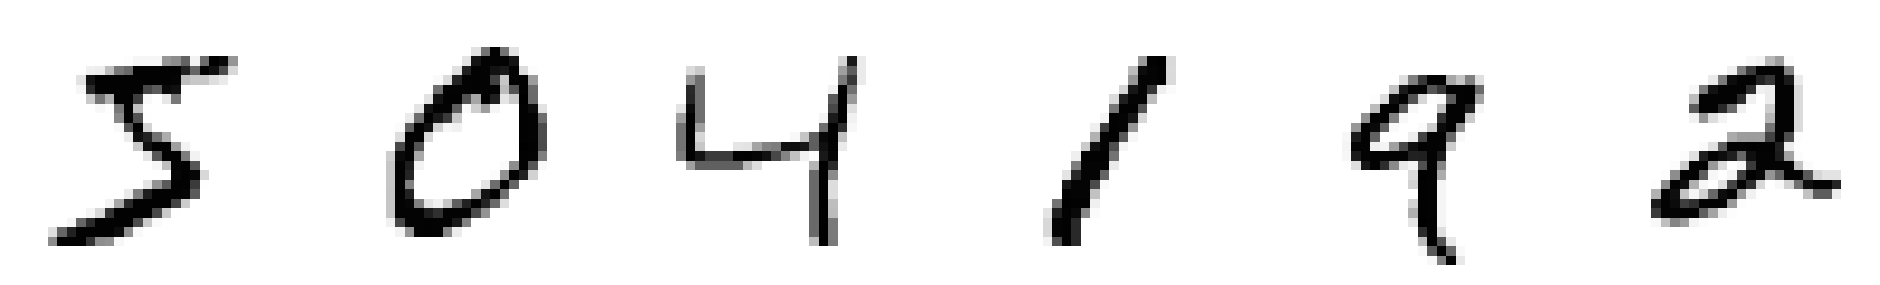

In [1]:
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from torch import nn
import torch

train_df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')

# Training data
X_train = train_df[train_df.columns[1:]] / 255
X_train = X_train.to_numpy().reshape((-1, 28, 28))
y_train = train_df['label']

# Testing data
X_test = test_df[test_df.columns[1:]] / 255
X_test = X_test.to_numpy().reshape((-1, 28, 28))
y_test = np.array(test_df['label'])

# Reduce size of dataset for speed
X_train = X_train[:10000]
y_train = np.array(y_train[:10000])

def generate_batch_indices(data, batch_size):
    n_samples = len(data)
    indices = [*range(n_samples)]
    np.random.shuffle(indices)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        yield indices[start_idx: end_idx]
        
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)

# Plot some MNIST images
n_images = 6
fig, axes = plt.subplots(1, n_images, figsize=(n_images*4, 4))

for idx in range(n_images):
    image = X_train[idx]
    axes[idx].imshow(image, cmap='Greys')
    axes[idx].axis('off')

### VAE PyTorch Model
We'll use this same neural network architecture for both models to keep things consistent.

This is a standard VAE model that uses strided convolution to simultaneously learn feature maps and downsample in the encoder, and nearest neighbour interpolated upsampling combined with convolution layers in the decoder, a method used by [Tero et al.](https://arxiv.org/abs/1710.10196) in training GANs.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Model size parameters
        n_channels = 32
        dense_size = 64
        
        input_shape = (28, 28)
        conv_out_shape = (n_channels, 7, 7)
        
        # Encoder, simple convnet using strided downsampling
        self.en_conv_1 = nn.Conv2d(in_channels=1, out_channels=n_channels//2, kernel_size=4, stride=2, padding=1)
        self.en_conv_2 = nn.Conv2d(n_channels//2, n_channels, kernel_size=4, stride=2, padding=1)
        
        self.en_dense_1 = nn.Linear(np.prod(conv_out_shape), dense_size)
        self.en_dense_2 = nn.Linear(dense_size, dense_size//2)
        
        self.en_mean = nn.Linear(dense_size//2, 2)
        self.en_log_var = nn.Linear(dense_size//2, 2)
        
        # Decoder, dense base into convolved nearest neighbour interpolated upsampling
        self.de_dense_1 = nn.Linear(2, dense_size//2)
        self.de_dense_2 = nn.Linear(dense_size//2, dense_size)
        self.de_dense_3 = nn.Linear(dense_size, np.prod(conv_out_shape))
        
        self.de_conv_1 = nn.Conv2d(n_channels, n_channels//2, kernel_size=5, stride=1, padding=2)
        self.de_conv_2 = nn.Conv2d(n_channels//2, n_channels//4, kernel_size=5, stride=1, padding=2)
        self.de_conv_3 = nn.Conv2d(n_channels//4, 1, kernel_size=1, stride=1, padding=0)
        
        # Auxiliary
        self.flatten = nn.Flatten()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
    def encode(self, x):
        x = F.leaky_relu(self.en_conv_1(x))
        x = F.leaky_relu(self.en_conv_2(x))
        x = self.flatten(x)
        x = F.leaky_relu(self.en_dense_1(x))
        x = F.leaky_relu(self.en_dense_2(x))
        mean = self.en_mean(x)
        log_var = self.en_log_var(x)
        return mean, log_var
    
    def sample(self, mean, log_var):
        std = (0.5 * log_var).exp()
        epsilon = torch.randn_like(mean)
        return (epsilon * std) + mean
    
    def decode(self, x):
        conv_out_shape = (32, 7, 7)
        x = F.leaky_relu(self.de_dense_1(x))
        x = F.leaky_relu(self.de_dense_2(x))
        x = F.leaky_relu(self.de_dense_3(x))
        x = x.view((-1, *conv_out_shape))
        x = F.leaky_relu(self.upsample(x))
        x = F.leaky_relu(self.de_conv_1(x))
        x = F.leaky_relu(self.upsample(x))
        x = F.leaky_relu(self.de_conv_2(x))
        x = F.sigmoid(self.de_conv_3(x))
        return x
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        x = self.sample(mean, log_var)
        x = self.decode(x)
        return x
    
    def set_encoder_grad(self, requires_grad):
        encoder_layers = [self.en_conv_1, self.en_conv_2, self.en_dense_1, self.en_dense_2, self.en_mean, self.en_log_var]
        for layer in encoder_layers:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def freeze_encoder(self):
        self.set_encoder_grad(False)

    def unfreeze_encoder(self):
        self.set_encoder_grad(True)

### Training the Models: Vanilla VAE vs. t-SNE VAE
In this step, we train the two VAEs: the standard (vanilla) VAE, and another integrated with t-SNE embeddings, which we'll call the t-SNE VAE.
Both models are trained without access to the image labels, only the 28 x 28 image pixel data.

#### Vanilla VAE Training:
The Vanilla VAE learns to convert an image into a probability distribution in the latent space. From this distribution, it samples a 2D point and reconstructs the image. To ensure a well-structured latent space, we introduce a `kl_loss` that encourages the distributions to approximate a standard normal distribution (mean = 0, variance = 1). This regularisation creates continuity in the latent space, hopefully increasing validation performance.

#### t-SNE VAE Training:
For the t-SNE VAE, we first use t-SNE to generate a 2D embedding for each image in our dataset. The encoder is then trained to produce the same mappings as those produced by t-SNE. After this, we then train the model on image reconstruction, similarly to the Vanilla VAE, but with the encoder's weights frozen to preserve the t-SNE-derived structure in the encoder.

In [3]:
### Vanilla VAE training functions ###
def calculate_vae_loss(inputs, prediction, mean, log_var):
    loss_reproduction = nn.functional.binary_cross_entropy(prediction.view(-1, 28*28), inputs.view(-1, 28*28), reduction='sum')
    loss_kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return loss_reproduction + loss_kl

def train_vae(model, optimizer, epochs, device):
    print("\nTraining vanilla VAE model...")
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, batch_indices in enumerate(generate_batch_indices(input_tensor,batch_size)):
            inputs = input_tensor[batch_indices].reshape(-1, 1, 28, 28)

            optimizer.zero_grad()

            mean, log_var = model.encode(inputs)
            prediction = model.decode(model.sample(mean, log_var))
            loss = calculate_vae_loss(inputs, prediction, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        # print(f"\tEpoch {epoch + 1} \tAverage Loss:  {overall_loss/(batch_idx*batch_size):.3f}")
    print("Vanilla VAE training complete.")
        

### t-SNE model training functions ###
def tsne_encoder_loss(target, prediction):
    loss = nn.functional.mse_loss(prediction.view(-1, 2), target.view(-1, 2))
    return loss

def tsne_decoder_loss(inputs, prediction):
    loss_reproduction = nn.functional.binary_cross_entropy(prediction.view(-1, 28*28), inputs.view(-1, 28*28), reduction='sum')
    return loss_reproduction 

def train_tsne_encoder(model, optimizer, epochs, device):
    print("\nTraining t-SNE model encoder...")
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, batch_indices in enumerate(generate_batch_indices(input_tensor, batch_size)):
            inputs = input_tensor[batch_indices].reshape(-1, 1, 28, 28)
            target = tsne_target[batch_indices]

            optimizer.zero_grad()

            prediction, _ = model.encode(inputs)
            loss = tsne_encoder_loss(target, prediction)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        # print(f"\tEpoch {epoch + 1} \tAverage Loss:  {overall_loss/(batch_idx*batch_size):.5f}")
    print("t-SNE model encoder training complete.")
        
def train_tsne_decoder(model, optimizer, epochs, device):
    print("\nTraining t-SNE model decoder...")
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, batch_indices in enumerate(generate_batch_indices(input_tensor,batch_size)):
            inputs = input_tensor[batch_indices].reshape(-1, 1, 28, 28)

            optimizer.zero_grad()

            mean, _ = model.encode(inputs)
            prediction = model.decode(mean)
            loss = tsne_decoder_loss(inputs, prediction)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        # print(f"\tEpoch {epoch + 1} \tAverage Loss:  {overall_loss/(batch_idx*batch_size):.3f}")
    print("t-SNE model training complete.")
    
    
### Learn t-SNE embeddings ###
from sklearn.manifold import TSNE

# t-SNE needs images shaped like (-1, n_dimensions)
images = X_train.reshape(-1, 28 * 28) 

# Apply t-SNE 
tsne = TSNE(n_components=2, random_state=42)
print("t-SNE transform in progress...")
tsne_reduced_data = tsne.fit_transform(images)
print('t-SNE transform completed.')

tsne_target = (torch.tensor(tsne_reduced_data, dtype=torch.float32) / 40).to(device) # Reduces t-SNE scale down to a similar one the vanilla VAE learns


### Vanilla VAE training ###
batch_size = 128
learning_rate = 1e-3

vanilla_model = VAE().to(device)
vanilla_optimizer = torch.optim.Adam(vanilla_model.parameters(), lr=learning_rate)
train_vae(vanilla_model, vanilla_optimizer, epochs=50, device=device)


### t-SNE VAE training ###
# First train encoder
tsne_model = VAE().to(device)
tsne_encoder_optimizer = torch.optim.Adam(tsne_model.parameters(), lr=learning_rate)
train_tsne_encoder(tsne_model, tsne_encoder_optimizer, epochs=20, device=device)

# Then train decoder
tsne_model.freeze_encoder()
tsne_optimizer = torch.optim.Adam(tsne_model.parameters(), lr=learning_rate)
train_tsne_decoder(tsne_model, tsne_optimizer, epochs=15, device=device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


t-SNE transform in progress...
t-SNE transform completed.

Training vanilla VAE model...
Vanilla VAE training complete.

Training t-SNE model encoder...
t-SNE model encoder training complete.

Training t-SNE model decoder...
t-SNE model training complete.


### Comparing Latent Space Quality
Let's compare the embedding spaces generated by the Vanilla VAE and t-SNE VAE to see how each model groups the MNIST digits. 

We're looking to identify tighter clusters for similarly written digits and broader clusters for digits with varied styles. We also expect similar looking digits to be positioned close to each other. Large gaps between clusters also indicate the model may perform worse in validation as points sampled from these areas may behave unpredictably.

In [4]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors

# Keep colours the same for the same number between plots
color_palette = plotly.colors.qualitative.Plotly

# Vanilla encodings
encodings_mean_vanilla, _ = vanilla_model.encode(input_tensor.reshape(-1, 1, 28, 28))
encodings_vanilla = encodings_mean_vanilla.detach().cpu().numpy()

# t-SNE encodings
encodings_mean_tsne, _ = tsne_model.encode(input_tensor.reshape(-1, 1, 28, 28))
encodings_tsne = encodings_mean_tsne.detach().cpu().numpy()

# Labels for colours
labels = y_train[:10000]


fig = make_subplots(rows=1, cols=2, subplot_titles=('Visualised Encodings from Vanilla Model', 'Visualised Encodings from TSNE Model'))

for i in range(10):
    subset_vanilla = encodings_vanilla[labels == i]
    subset_tsne = encodings_tsne[labels == i]
    
    color = color_palette[i % len(color_palette)]
    
    # Vanilla VAE plot
    fig.add_trace(go.Scatter(x=subset_vanilla[:, 0], y=subset_vanilla[:, 1], 
                             mode='markers', 
                             name=f'Label {i} (Vanilla)', 
                             marker=dict(color=color)), 
                             row=1, col=1)
    
    # t-SNE plot
    fig.add_trace(go.Scatter(x=subset_tsne[:, 0], y=subset_tsne[:, 1], 
                             mode='markers', 
                             name=f'Label {i} (TSNE)', 
                             marker=dict(color=color)),
                             row=1, col=2)

fig.update_layout(
    width=1200,
    height=600,
)

fig.update_xaxes(title_text='Encoding Dimension 1', scaleanchor="y", scaleratio=1, range=[-2, 2], row=1, col=1)
fig.update_yaxes(title_text='Encoding Dimension 2', range=[-2, 2], row=1, col=1)

fig.update_xaxes(title_text='t-SNE 1', scaleanchor="y", scaleratio=1, range=[-2, 2], row=1, col=2)
fig.update_yaxes(title_text='t-SNE 2', range=[-2, 2], row=1, col=2)

fig.show()

#### Continuous Latent Space Plots
These plots hope to make clear the quality of the whole latent space, including regions that aren't utilised by the encoder.

By plotting decoded images at regular intervals within the latent space, we can see how each model transitions between different digit representations.

This also helps give us an idea of the generalisation abilities of each model.

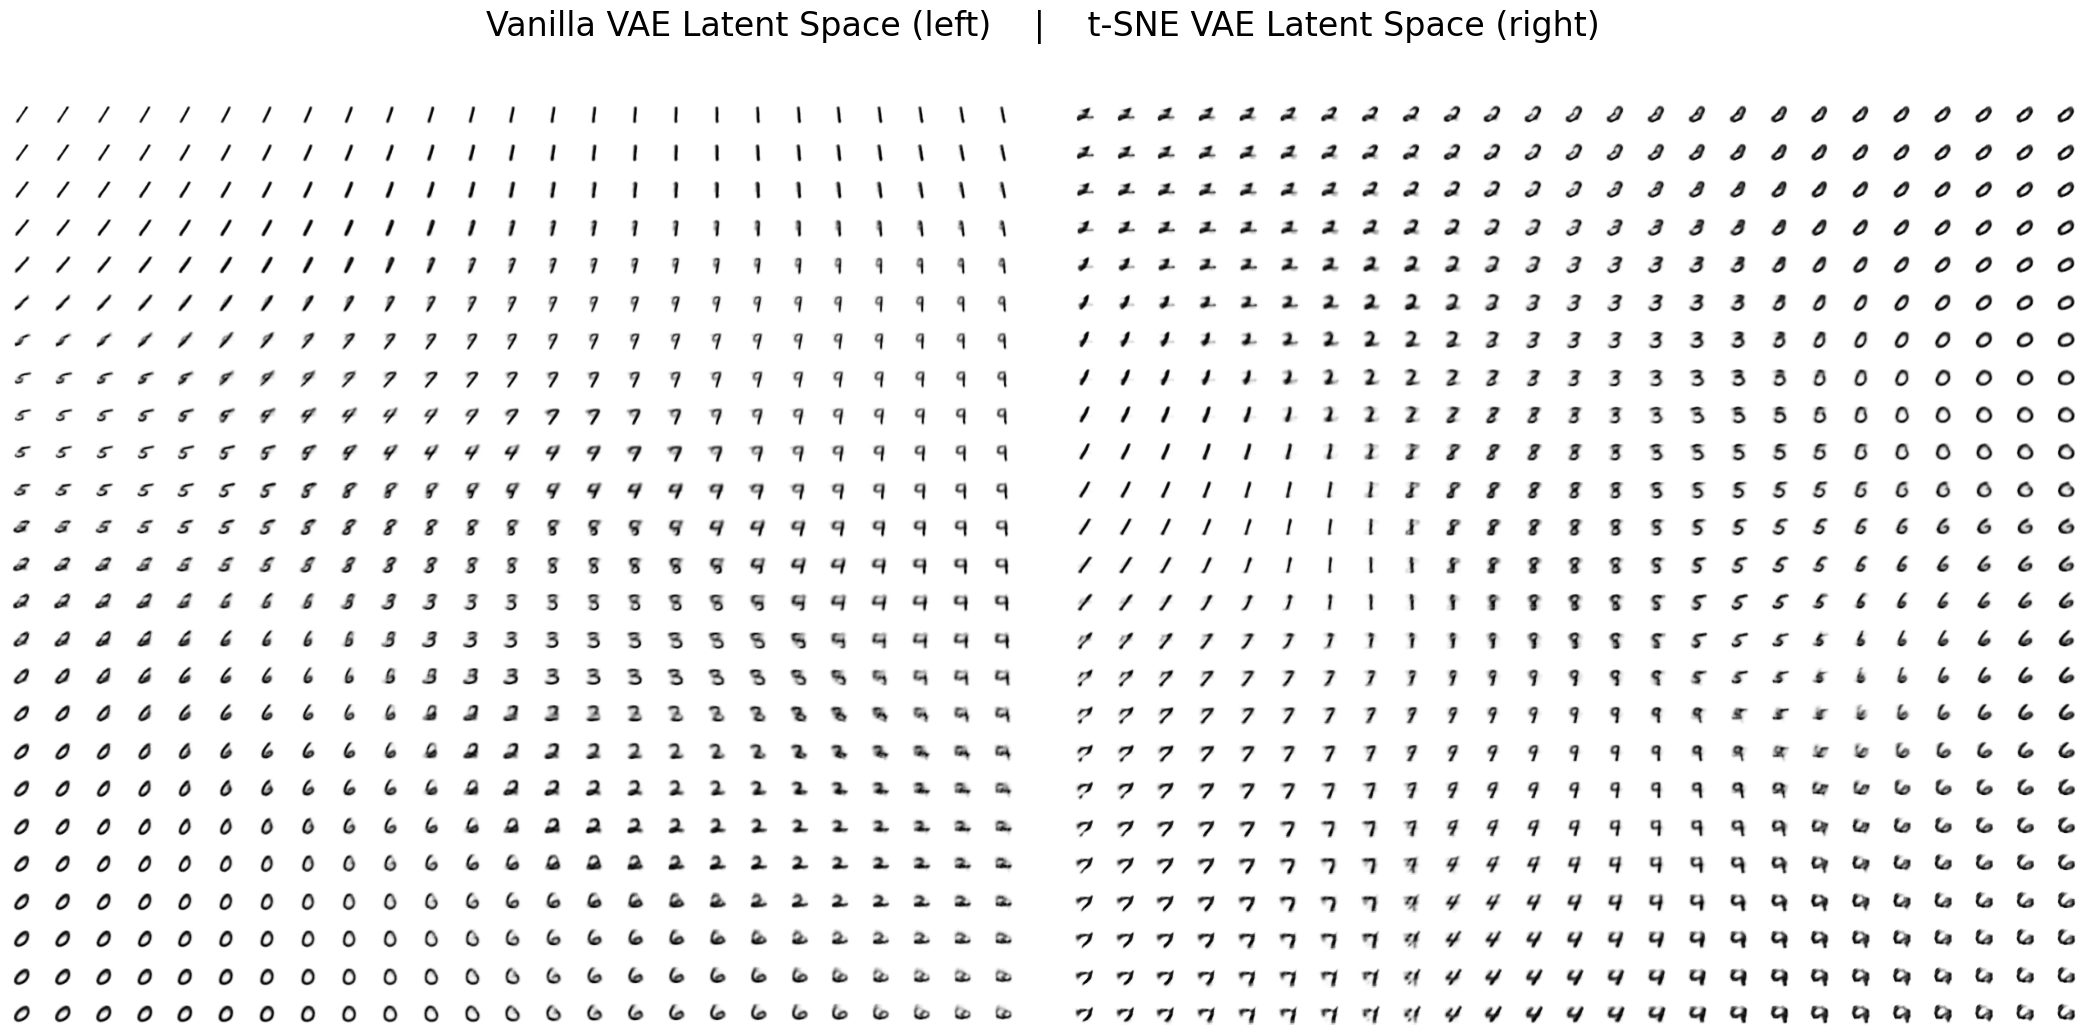

In [5]:
# Number of points to build each image with
n_points = 25

x_domain = np.linspace(-2, 2, n_points)
y_domain = np.linspace(-2, 2, n_points)

x, y = np.meshgrid(x_domain, y_domain)

coordinates = np.stack((x.reshape(-1), y.reshape(-1)), axis=-1).reshape(-1, 2)
coordinate_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)

# Decode coordinates using both models
vanilla_images = vanilla_model.decode(coordinate_tensor).detach().cpu().numpy().reshape(n_points, n_points, 28, 28)
tsne_images = tsne_model.decode(coordinate_tensor).detach().cpu().numpy().reshape(n_points, n_points, 28, 28)

# Include a separation column in the middle
fig, axes = plt.subplots(n_points, n_points * 2 + 1, figsize=(21, 10)) 

for x_idx in range(n_points):
    for y_idx in range(n_points):
        # Vanilla model plots on the left
        axes[x_idx, y_idx].imshow(1 - vanilla_images[x_idx, y_idx], cmap='gray')
        axes[x_idx, y_idx].axis('off')
        
        # Blank column for separation
        axes[x_idx, n_points].axis('off')  # Turn off axis for the middle, blank column
        
        # t-SNE model plots on the right, adjust index by adding 1 for the separation
        axes[x_idx, y_idx + n_points + 1].imshow(1 - tsne_images[x_idx, y_idx], cmap='gray')
        axes[x_idx, y_idx + n_points + 1].axis('off')

fig.suptitle('Vanilla VAE Latent Space (left)    |    t-SNE VAE Latent Space (right)', fontsize=24, y=1.03)
plt.tight_layout()
plt.show()

### Training SKLearn Classifiers on Learnt Encodings
Next, we use classifiers from the `scikit-learn` library to learn to classify points based on their location in the latent space. This should give us a good idea about how easily separable each latent space is, which is indicative of the quality.

We'll do this with the following approach:
#### Encode data
We first encode the MNIST dataset using our VAE models' encoders.
#### Training classifiers
We train two instances of the same classifier model (such as an SVM or a Decision Tree) on these encoded datasets. 

#### Testing and Visualisation
After training, we evaluate the classifiers on a test set and visualise the decision boundaries. For visualization, we use Plotly to create interactive plots that clearly show where the model draws boundaries between different classes based on the learnt encoded representations.

The lighter points in a translucent grey are correctly classified images, points marked in red are misclassified. We also only plot 1000 points on each plot instead of the full 10,000 test set, so it's not too busy.

#### Support Vector Machine (SVM) Classifier

In [6]:
### SKLearn classifier ###
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Training embedding arrays
X_train_vanilla = encodings_mean_vanilla.detach().cpu().numpy()
X_train_tsne = encodings_mean_tsne.detach().cpu().numpy()

# Validation data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28).to(device)
X_test_tsne_mean, _ = tsne_model.encode(X_test_tensor)
X_test_tsne = X_test_tsne_mean.detach().cpu().numpy()

X_test_vanilla_mean, _ = vanilla_model.encode(X_test_tensor)
X_test_vanilla = X_test_vanilla_mean.detach().cpu().numpy()


### Classifier decision boundary visualisation ###
def visualize_decision_boundaries(model, X_train_1, X_train_2, X_test_1, X_test_2, y_train, y_test, plot_proportion=0.1, title=None):
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Dataset 1", "Dataset 2"))

    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    
    labels = range(10)  # Labels from 0 to 9
    colorscale = plotly.colors.qualitative.Plotly
    
    # Map each label to a color
    label_color_map = {label: colorscale[label % len(colorscale)] for label in labels}

    # Vanilla and t-SNE datasets
    for i, (X_train, X_test) in enumerate(zip([X_train_1, X_train_2], [X_test_1, X_test_2]), start=1):
        # Fit the classifier
        model.fit(X_train, y_train)
        
        # Predict over the test data
        predictions = model.predict(X_test)

        # Create a meshgrid for the background colors
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        
        # Predict over the meshgrid for decision boundaries
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Correct and incorrect predictions
        correct_predictions = (predictions == y_test)
        incorrect_predictions = ~correct_predictions
        
        acc = sum(correct_predictions) / len(correct_predictions)
        if i == 1:
            print(f"Vanilla training accuracy: {100*acc:.1f}%", end='\t\t\t\t\t\t')
        else:
            print(f"t-SNE training accuracy: {100*acc:.1f}%")
        
        # Plot decision boundaries using contour plot for each subplot
        fig.add_trace(go.Contour(
            z=Z,
            x=np.linspace(x_min, x_max, 100),
            y=np.linspace(y_min, y_max, 100),
            colorscale=colorscale,
            showscale=False,  
            contours=dict(showlines=False),  
            name=f"Dataset {i} Decision Boundary", 
            showlegend=False
        ), row=1, col=i)
        
        # Add scatter plot for correctly predicted test points
        fig.add_trace(go.Scatter(
            x=X_test[correct_predictions, 0][:int(plot_proportion*len(y_test))],
            y=X_test[correct_predictions, 1][:int(plot_proportion*len(y_test))],
            mode='markers',
            marker=dict(color='grey', opacity=0.1, size=3),
            name='Correct Prediction',
            showlegend=False
        ), row=1, col=i)
        
        # Add another scatter plot for incorrectly predicted test points
        fig.add_trace(go.Scatter(
            x=X_test[incorrect_predictions, 0][:int(plot_proportion*len(y_test))],
            y=X_test[incorrect_predictions, 1][:int(plot_proportion*len(y_test))],
            mode='markers',
            marker=dict(color='red', opacity=0.5, size=3),
            name='Incorrect Prediction',
            showlegend=False
        ), row=1, col=i)
        
    # Add a dummy scatter plot for each label to create a legend
    for label, color in label_color_map.items():
        fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                                 marker=dict(size=10, color=color),
                                 name=str(label)), row=1, col=1)

    # Update layout for subplots
    fig.update_layout(
        title='Decision Boundary Visualization' if title is None else title,
        xaxis_title='Feature 1',
        xaxis2_title='Feature 1',
        yaxis_title='Feature 2',
        yaxis2_title='Feature 2',
        width=1200,
        height=600,
        legend_title_text='Labels'
    )

    # Update xaxis and yaxis range for both subplots to ensure they are identical
    fig.update_xaxes(range=[x_min, x_max], row=1, col=1)
    fig.update_xaxes(range=[x_min, x_max], row=1, col=2)
    fig.update_yaxes(range=[y_min, y_max], row=1, col=1)
    fig.update_yaxes(range=[y_min, y_max], row=1, col=2)

    fig.show()

    
# SVM classifer model with radial basis function for non-linearity
svm = SVC(kernel='rbf')
visualize_decision_boundaries(svm, X_train_vanilla, X_train_tsne, X_test_vanilla, X_test_tsne, y_train, y_test, title='SVM Decision Boundary Visualisation')

Vanilla training accuracy: 69.3%						t-SNE training accuracy: 86.2%


#### Decision Tree Classifier

In [7]:
# Regulated decision tree classifer to help combat overfitting
dtc = DecisionTreeClassifier(max_depth=7)
visualize_decision_boundaries(dtc, X_train_vanilla, X_train_tsne, X_test_vanilla, X_test_tsne, y_train, y_test, title='Decision Tree Decision Boundary Visualisation')

Vanilla training accuracy: 67.5%						t-SNE training accuracy: 84.7%


#### K-Nearest Neighbours Classifier

In [8]:
# K-Neighbours with 10 neighbours
knc = KNeighborsClassifier(n_neighbors=10)
visualize_decision_boundaries(knc, X_train_vanilla, X_train_tsne, X_test_vanilla, X_test_tsne, y_train, y_test, title='KNN Decision Boundary Visualisation')

Vanilla training accuracy: 68.2%						t-SNE training accuracy: 85.6%


### Viewing Reconstructed Images
We'll now pass validation data through our autoencoders to compare the quality of the digit images each one produces compared to the ground truth images.

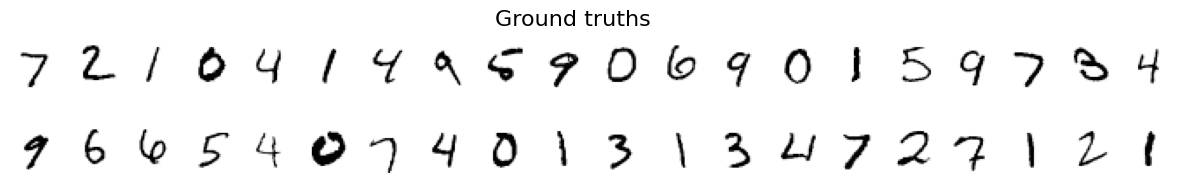

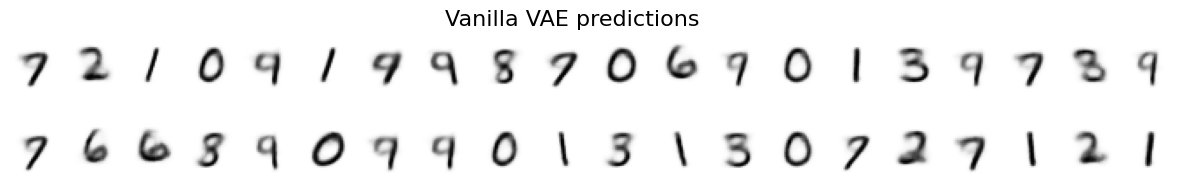

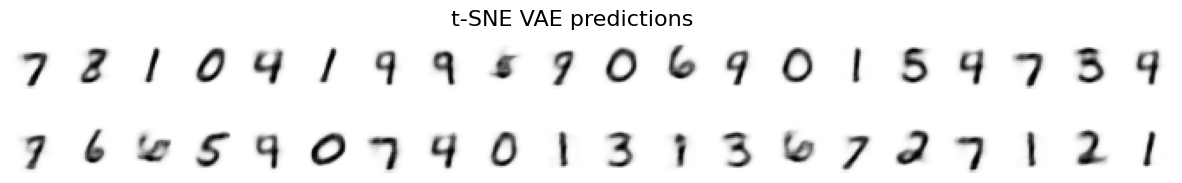

In [9]:
mean_vanilla_model, _ = vanilla_model.encode(X_test_tensor)
preds_vanilla_model = vanilla_model.decode(mean_vanilla_model)
preds_vanilla_model = preds_vanilla_model.detach().cpu().numpy().reshape(-1, 28, 28)

mean_tsne_model, _ = tsne_model.encode(X_test_tensor)
preds_tsne_model = tsne_model.decode(mean_tsne_model)
preds_tsne_model = preds_tsne_model.detach().cpu().numpy().reshape(-1, 28, 28)

n_images = 20
# Function to help plot images in a grid
def plot_images(fig, axes, images, title, nrows=2, ncols=20):
    plt.suptitle(title, fontsize=16)
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j  # Calculate index for the image
            if idx < len(images):  # Check to avoid index error
                ax = axes[i, j]
                ax.imshow(images[idx], cmap='Greys')
                ax.axis('off')
            else:  # Turn off axis if no image is available
                axes[i, j].axis('off')

# Ground truths
fig, axes = plt.subplots(2, n_images, figsize=(15, 2))  # Adjusted for 2 rows
plot_images(fig, axes, X_test[:n_images*2], 'Ground truths')  # Plotting twice the number of n_images
plt.show()

# Vanilla VAE predictions
fig, axes = plt.subplots(2, n_images, figsize=(15, 2))  # Adjusted for 2 rows
plot_images(fig, axes, preds_vanilla_model[:n_images*2], 'Vanilla VAE predictions')  # Plotting twice the number of n_images
plt.show()

# t-SNE VAE predictions
fig, axes = plt.subplots(2, n_images, figsize=(15, 2))  # Adjusted for 2 rows
plot_images(fig, axes, preds_tsne_model[:n_images*2], 't-SNE VAE predictions')  # Plotting twice the number of n_images
plt.show()


### Evaluating Reconstruction Loss on Validation Data
Finally, we'll use our fully-trained autoencoder models in the way they're intended to be used.

We'll input validation images the models haven't seen before, and see how they do at reconstructing them. 

Since we're using binary cross-entropy loss, it's not going to be intuitive how much one model is better than the other, so instead of aggregating the loss over the dataset, we'll calculate loss per image and compare which model produces images with the lower loss on average.

In [10]:
# Convert to torch tensors so we can use torch BCE
preds_vanilla_model_tensor = torch.tensor(preds_vanilla_model.reshape(-1, 28*28), dtype=torch.float)
preds_tsne_model_tensor = torch.tensor(preds_tsne_model.reshape(-1, 28*28), dtype=torch.float)
y_test_tensor = torch.tensor(X_test.reshape(-1, 28*28), dtype=torch.float)

# Calculate BCE loss for each image
loss_vanilla = F.binary_cross_entropy(preds_vanilla_model_tensor, y_test_tensor, reduction='none').mean(dim=1)
loss_tsne = F.binary_cross_entropy(preds_tsne_model_tensor, y_test_tensor, reduction='none').mean(dim=1)

# Compare losses for each image
tsne_better_count = (loss_tsne < loss_vanilla).sum().item()
total_images = y_test_tensor.shape[0]
tsne_better_percentage = (tsne_better_count / total_images) * 100

print(f"t-SNE model's BCE loss is lower than the vanilla model's BCE on {tsne_better_percentage:.2f}% of images.")

t-SNE model's BCE loss is lower than the vanilla model's BCE on 34.83% of images.
